# Program Dependence and Slicing

We have so far explored control dependencies and data dependencies independently. These two concepts are related as they both represent cases of _program_ dependencies. In this chapter, we will define the program dependence graph, and use this to implement _slicing_.

## Control Dependencies

First we need to include all the CFG-related code.

In [1]:
import javalang

In [2]:
class CFGNode:
    def __init__(self, graph, method_name, ast_node):
        self.graph = graph
        self.method_name = method_name
        self.ast_node = ast_node
        
    def __str__(self):
        if type(self.ast_node) == str:
            return self.ast_node
        else:
            return str(self.ast_node.position.line - 1)

In [3]:
class StartNode:
    
    def __init__(self, graph, method_name, ast_node):
        self.graph = graph
        self.method_name = method_name
        self.ast_node = ast_node
    
    def __str__(self):
        return "Start"

In [4]:
import networkx as nx

In [5]:
class ProgramGraph:
    def __init__(self, graph, start, end):
        self.graph = graph
        self.start = start
        self.end   = end
        
    def nodes(self):
        return self.graph.nodes()
    
    def edges(self):
        return self.graph.edges()
    
    def successors(self, node):
        return self.graph.successors(node)
    
    def predecessors(self, node):
        return self.graph.predecessors(node)
    
    def reverse(self):
        reverse_cfg = self.graph.reverse()
        return ProgramGraph(reverse_cfg, self.end, self.start)    
    
    def node_for_line(self, line_no):
        for node in self.nodes():
            if str(node) == str(line_no):
                return node
        return None
    
    def plot(self):
        pos = nx.nx_agraph.graphviz_layout(self.graph, prog="dot")
        nx.draw_networkx_nodes(self.graph, pos=pos, node_size=800, node_color='#FFFFFF', edgecolors='#000000')
        nx.draw_networkx_edges(self.graph, pos=pos, connectionstyle="arc", arrowsize=20)
        nx.draw_networkx_labels(self.graph, pos=pos)
        nx.draw_networkx_edge_labels(self.graph, pos=pos, edge_labels=nx.get_edge_attributes(self.graph,'label'))

In [6]:
from functools import singledispatchmethod

In [7]:
class CFGBuilder:
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        self.method_name = method_declaration.name
        
        # create entry/end node
        self.start = StartNode(self.graph, self.method_name, method_declaration)
        self.end   = CFGNode(self.graph, self.method_name, "End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

    def create_graph(self):
        return ProgramGraph(self.graph, self.start, self.end)
    
    @singledispatchmethod
    def add_node(self, node):
        pass
    
    @add_node.register        
    def add_block_node(self, block_node: javalang.tree.BlockStatement):
        for node in block_node.statements:
            self.add_node(node)            
    
    @add_node.register
    def add_statement_node(self, node: javalang.tree.StatementExpression):
        cfg_node = CFGNode(self.graph, self.method_name, node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        
    @add_node.register
    def add_declaration_node(self, node: javalang.tree.LocalVariableDeclaration):
        self.add_statement_node(node)
        
    @add_node.register
    def add_if_node(self, if_node: javalang.tree.IfStatement):
        cfg_node = CFGNode(self.graph, self.method_name, if_node)
        self.graph.add_node(cfg_node)

        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(if_node.then_statement)
        
        if if_node.else_statement:
            current_frontier = self.frontier[:]
            self.frontier = [cfg_node]
            self.add_node(if_node.else_statement)
            self.frontier.extend(current_frontier)
        else:
            self.frontier.append(cfg_node)
            
    @add_node.register
    def add_while_node(self, while_node: javalang.tree.WhileStatement):
        cfg_node = CFGNode(self.graph, self.method_name, while_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(while_node.body)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]

    @add_node.register
    def add_return_node(self, return_node: javalang.tree.ReturnStatement):
        cfg_node = CFGNode(self.graph, self.method_name, return_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.graph.add_edge(cfg_node, self.end)
        self.frontier = [] 

In [8]:
def parse_method(code):
    class_code = "class Dummy {\n" + code + "\n}";
    tokens = javalang.tokenizer.tokenize(class_code)
    parser = javalang.parser.Parser(tokens)
    ast = parser.parse()
    _, node = list(ast.filter(javalang.tree.MethodDeclaration))[0]
    return node

To recall, here's an example method for which we can view the control flow graph.

In [9]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        if(x % 2 == 0)
            y += x;
        x--;
    }

    return y;
  }
"""

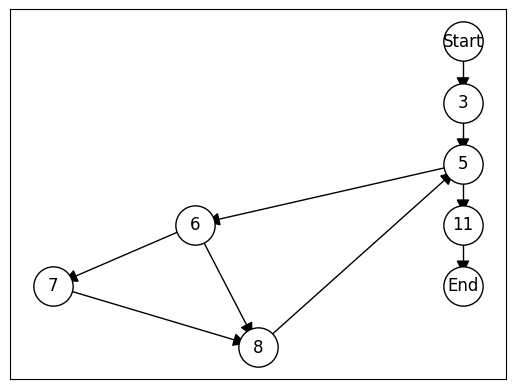

In [10]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Based on the CFG we defined the notion of dominance, and the resulting dominator tree.

In [11]:
class ProgramGraph(ProgramGraph):
    def dominators(self):
        entry = self.start
        remaining_nodes = [node for node in self.nodes() if node != entry]

        # D(entry) <- {entry}
        dominators = {}
        dominators[entry] = [entry]

        # D(node \ {entry}) <- nodes
        for node in remaining_nodes:
            dominators[node] = set(self.nodes())

        changed = True
        while changed:
            changed = False

            for node in remaining_nodes:
                current_dominators = dominators[node]

                # new_dominators = node \cup intersection(dominators for all predecessors)
                new_dominators = set(self.nodes())

                for p in self.predecessors(node):
                    new_dominators = new_dominators.intersection(dominators[p])

                new_dominators.add(node)

                if new_dominators.symmetric_difference(current_dominators):
                    dominators[node] = new_dominators
                    changed = True

        return dominators

In [12]:
class ProgramGraph(ProgramGraph):
    def strict_dominators(self):
        dominators = self.dominators()
        for node, dom in dominators.items():
            dom.remove(node)
        return dominators

In [13]:
def dominator_tree(cfg):
    dt = nx.DiGraph()
    dt.add_nodes_from(cfg.nodes())
    dominator_map = cfg.strict_dominators()
    queue = [ cfg.start ]
    while queue:
        current = queue.pop()
        for node in cfg.nodes():            
            dominators = dominator_map[node]
            
            if current in dominators:
                dominators.remove(current)
                if not dominators:
                    dt.add_edge(current, node)
                    queue.append(node)

    return ProgramGraph(dt, cfg.start, cfg.end)

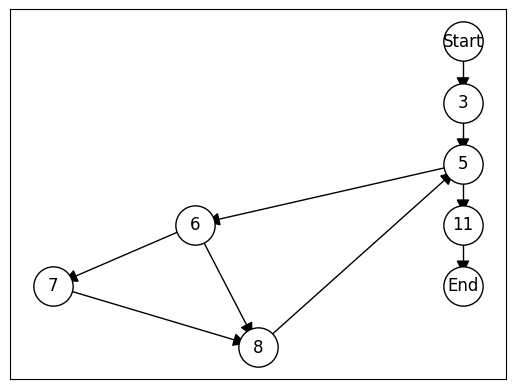

In [14]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

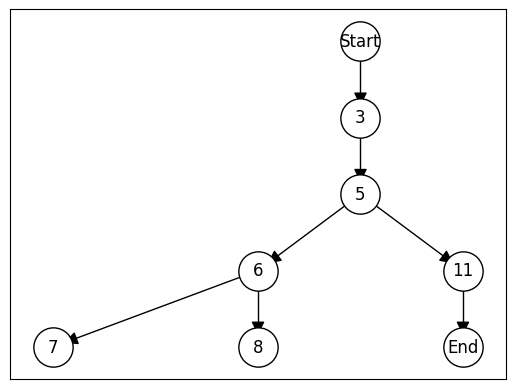

In [15]:
dominator_tree(cfg).plot()

The postdominators are determined simply by applying the same on the reversed CFG.

In [16]:
class ProgramGraph(ProgramGraph):
    def reverse(self):
        reverse_cfg = self.graph.reverse()
        return ProgramGraph(reverse_cfg, self.end, self.start)

In [17]:
class ProgramGraph(ProgramGraph):
    def post_dominators(self):
        rcfg = self.reverse()
        return rcfg.dominators()

In [18]:
def postdominator_tree(cfg):
    rcfg = cfg.reverse()
    return dominator_tree(rcfg)

In [19]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()

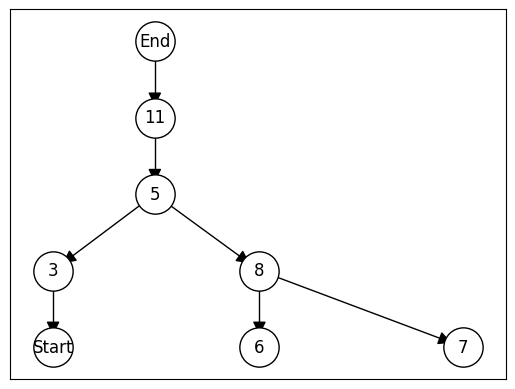

In [20]:
postdominator_tree(cfg).plot()

The postdominator tree allows us to determine the control dependencies in a program.

In [21]:
class ProgramGraph(ProgramGraph):
    def transitive_successors(self, node):
        return nx.nodes(nx.dfs_tree(self.graph, node))
    
    def least_common_ancestor(self, node1, node2):
        current = node1
        successors = self.transitive_successors(current)

        while not (node1 in successors) or not (node2 in successors):
            current = list(self.graph.predecessors(current))[0]
            successors = self.transitive_successors(current)
        
        return current  

In [22]:
class ProgramGraph(ProgramGraph):
    def is_reachable(self, source, target):
        successors = self.transitive_successors(source)
        return target in successors

In [23]:
class ProgramGraph(ProgramGraph):
    def in_degree(self, node):
        return self.graph.in_degree(node)

In [24]:
def control_dependence_graph(cfg):
    pdt = postdominator_tree(cfg)
    cdg = nx.DiGraph()
    cdg.add_nodes_from(cfg.nodes())
    
    # 1. Find S, a set of edges (a,b) in the CFG such that
    # b is not an ancestor of a in the post-dominator tree.
    edges = set()
    for a, b in cfg.edges():
        if not pdt.is_reachable(b, a):
            edges.add((a, b))

    for a, b in edges:
        # 2. For each edge (a,b) in S, find L, the least common ancestor
        # of a and b in the post-dominator tree.
        lca = pdt.least_common_ancestor(a, b)

        # Traverse backwards in the post-dominator tree from b to L,
        # marking each node visited; mark L only if L = a.
        # Statements representing all marked nodes are control dependent on a.
        current = b
        while current != lca:
            cdg.add_edge(a, current)
            current = list(pdt.predecessors(current))[0]

        if a == lca:
            cdg.add_edge(a, lca)

    # Any nodes not connected at this point are only dependent on entry
    entry = cfg.start
    for node in cdg.nodes():
        if node != entry and (cdg.in_degree(node) == 0 or list(cdg.predecessors(node)) == [node]):
            cdg.add_edge(entry, node)

    return ProgramGraph(cdg, cfg.start, cfg.end)

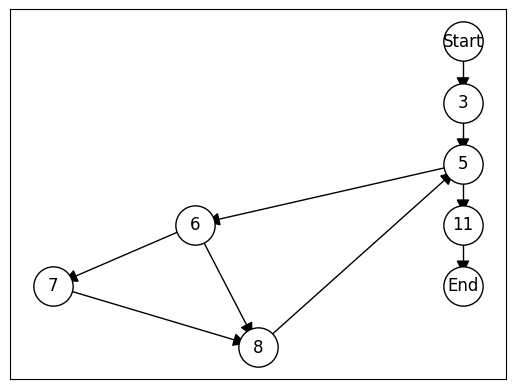

In [25]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

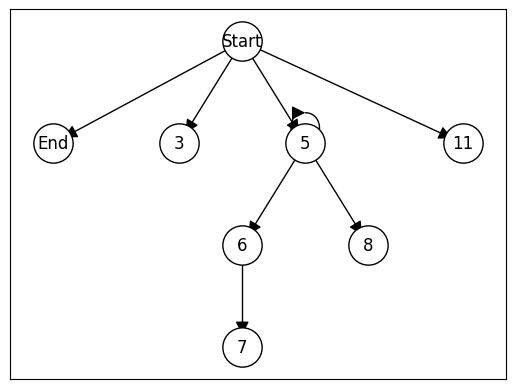

In [26]:
control_dependence_graph(cfg).plot()

## Control Dependencies via Dominance Frontier

Before we move on to data dependencies, we will discuss an alternative way to determine the control dependencies.

For a CFG and node x, the dominance frontier DF(x) is the set of all nodes y in the CFG such that x dominates an immediate predecessor of y but does not strictly dominate y. The dominance frontier for node $n$ consists of two parts:
1. DFlocal: The successors of $n$ in the CFG that are not strictly dominated by $n$
2. DFup: Nodes in the dominance frontier of $n$ that are not dominated by $n$'s immediate dominator

The dominance frontier for node $n$ consists of DFlocal(n) and DFup(c) for each child c whose immediate dominator is $n$. We thus need to add a method to calculate the immediate dominators, which we previously defined in the lecture but did not implement.

In [27]:
class ProgramGraph(ProgramGraph):
    def immediate_dominators(self):
        dominators = self.strict_dominators()
        idom = {} 
        for node in cfg.nodes():
            idom[node] = set(dominators[node])
            
            for dom in list(idom[node]):
                if set(dominators[dom]) & idom[node]:
                    idom[node] -= set(dominators[dom])
        return idom
        

In [28]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()

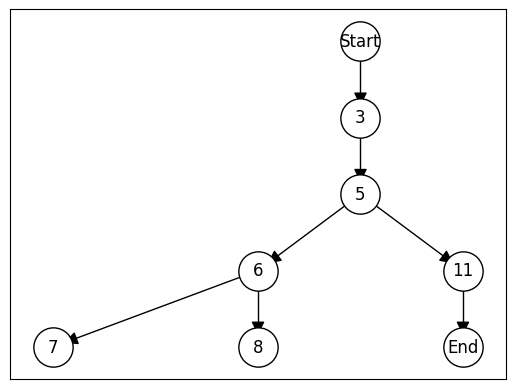

In [29]:
dominator_tree(cfg).plot()

In [30]:
for key, value in cfg.immediate_dominators().items():
    print(f"{key}: {[str(v) for v in value]}")

Start: []
End: ['11']
3: ['Start']
5: ['3']
6: ['5']
7: ['6']
8: ['6']
11: ['5']


The dominance frontier can now be calculated with the following algorithm:

In [31]:
def dominance_frontier(node, cfg):

    dominators = cfg.strict_dominators()
    dt = dominator_tree(cfg)
    idom = cfg.immediate_dominators()
    
    df = set()
    for succ in cfg.successors(node):
        if node not in idom[succ]:
            df.add(succ)
    
    for succ in dt.successors(node):
        dom_succ = dominance_frontier(succ, cfg)
        for n in dom_succ:
            if not node in dominators[n]:
                df.add(n)
    
    return df

For example, the dominance frontier of node 6 must be 5.

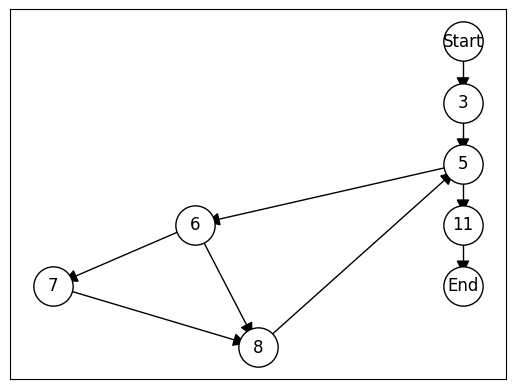

In [32]:
cfg.plot()

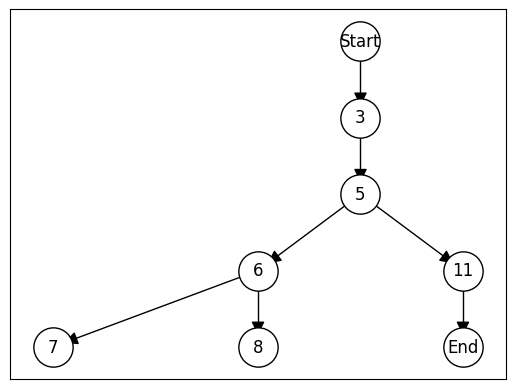

In [33]:
dominator_tree(cfg).plot()

In [34]:
node = cfg.node_for_line(6)
for n in dominance_frontier(node, cfg):
    print(str(n))

5


For a given node of the CFG, the control dependencies are the dominance frontiers on the reverse control flow graph. We can therefore also calculate the CDG by inverting the CFG, and then for each node calculate its dominance frontier; then add an edge from each node on the frontier to the node.

In [35]:
def control_dependencies2(cfg):
    rcfg = cfg.reverse()
    
    cdg = nx.DiGraph()
    cdg.add_nodes_from(cfg.nodes())

    for node in cfg.nodes():
        frontier = dominance_frontier(node, rcfg)
        for frontier_node in frontier:
            cdg.add_edge(frontier_node, node)

        # Nodes without parents are dependent only on entry
        if node != cfg.start and (cdg.in_degree(node) == 0 or list(cdg.predecessors(node)) == [node]):
            cdg.add_edge(cfg.start, node)
            
    return ProgramGraph(cdg, cfg.start, cfg.end)

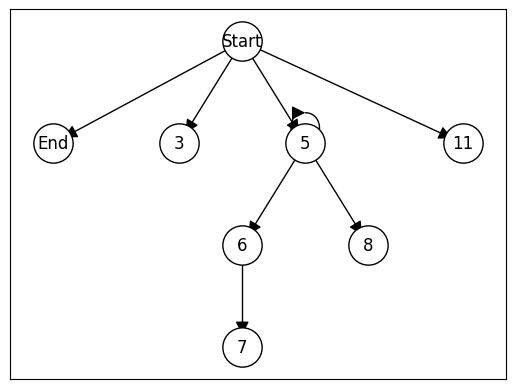

In [36]:
control_dependencies2(cfg).plot()

For reference, here is the CDG calculated with our previous algorithm.

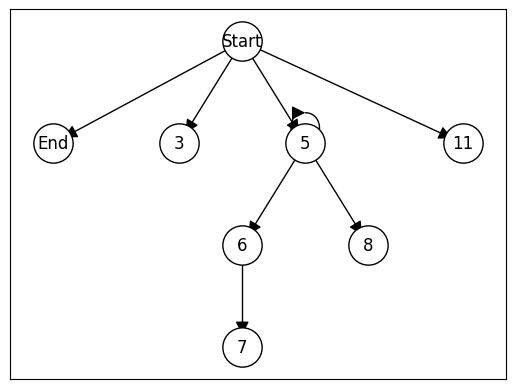

In [37]:
control_dependence_graph(cfg).plot()

Let's also revisit our lecture example.

In [38]:
code = """
public boolean testMe(int x, int y) {
    if (x <= y) {
        if (x == y) {
            System.out.println("Some output");
        }
        if (x > 0) {
            if (y == 17) {
               return true;
            }
        }
    }
    return false;
}
"""

In [39]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()

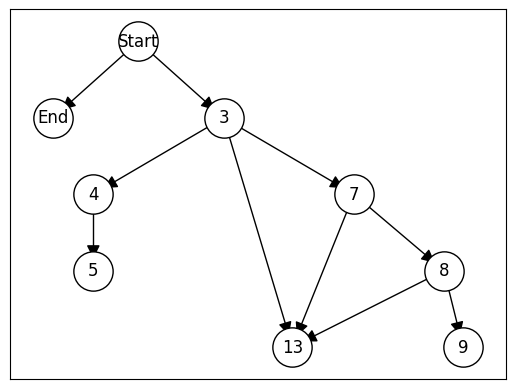

In [40]:
control_dependencies2(cfg).plot()

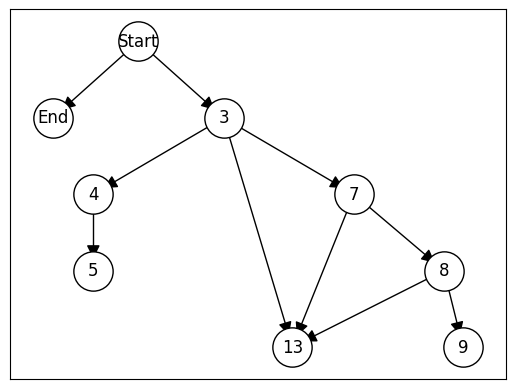

In [41]:
control_dependence_graph(cfg).plot()

## Data Dependencies

The second class of dependencies we considered are related to how data is written and propagated within a program. We distinguished between definitions and uses.

In [42]:
from dataclasses import dataclass

In [43]:
@dataclass(frozen=True, eq=True)
class Use:
    name: str
    node: CFGNode
        
    def __str__(self):
        if isinstance(self.node.ast_node, str):
            return f"Use: {self.name} in {self.node.ast_node}"
        
        return f"Use: {self.name} in line {self.node.ast_node.position.line - 1}"

In [44]:
class CFGNode(CFGNode):
    def uses(self):
        uses = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return uses
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
        elif isinstance(self.ast_node, javalang.tree.StatementExpression):
            # Assignment: lhs only if it is a +=, -=, etc
            if isinstance(self.ast_node.expression, javalang.tree.Assignment):
                if len(self.ast_node.expression.type) > 1:
                    root = self.ast_node.expression
                else:
                    root = self.ast_node.expression.value
            
        for _, node in root.filter(javalang.tree.MemberReference):
            uses.add(Use(node.member, self))
        for _, node in root.filter(javalang.tree.MethodInvocation):
            uses.add(Use(node.qualifier, self)) # Only works for non-static methods
        return uses

In [45]:
@dataclass(frozen=True, eq=True)
class Definition:
    name: str
    node: CFGNode
        
    def __str__(self):
        return f"Def: {self.name} in line {self.node.ast_node.position.line - 1}"

In [46]:
class CFGNode(CFGNode):
    def definitions(self):
        definitions = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return definitions
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
                    
        for _, node in root.filter(javalang.tree.LocalVariableDeclaration):
            decl = node.declarators[0]
            definitions.add(Definition(decl.name, self))
        for _, node in root.filter(javalang.tree.Assignment):
            memberref = node.expressionl
            definitions.add(Definition(memberref.member, self))
        for _, node in root.filter(javalang.tree.MemberReference):
            if node.prefix_operators or node.postfix_operators:
                definitions.add(Definition(node.member, self))
        return definitions

In [47]:
class StartNode(StartNode):
    def definitions(self):
        definitions = set()
        
        for _, node in self.ast_node.filter(javalang.tree.FormalParameter):
            definitions.add(Definition(node.name, self))
        
        return definitions
    
    def uses(self):
        return set()

To find our which definitions can reach which uses we need to apply dataflow analysis. 

In [48]:
class Lattice(object):
    def __init__(self, elements, join_func, meet_func):
        self.elements = elements
        self.join = join_func
        self.meet = meet_func

    def wrap(self, object):
        return LatticeElement(self, object)

    def element_by_index(self, index):
        return LatticeElement(self, self.elements[index])

    @property
    def top(self):
        top = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            top |= self.wrap(element)
        return top

    @property
    def bottom(self):
        bottom = self.wrap(self.elements[0])
        for element in self.elements[1:]:
            bottom &= self.wrap(element)
        return bottom
    
    def plot(self):
        dot = Digraph()
        
        graph = dict()
        for indexS, elementS in enumerate(self.elements):
            graph[indexS] = []
            for indexD, elementD in enumerate(self.elements):
                if self.wrap(elementS) <= self.wrap(elementD):
                    if not bool( sum([ int(self.element_by_index(x) <= self.wrap(elementD)) for x in graph[indexS]])) and not elementS == elementD:
                        graph[indexS] += [indexD]
        dot.node(str(self.top.unwrap))
        dot.node(str(self.bottom.unwrap))
        for s, ds in graph.items():
            for d in ds:
                dot.edge(str(self.element_by_index(s)), str(self.element_by_index(d)))

        return dot

    def __repr__(self):
        """Represents the lattice as an instance of Lattice."""
        return 'Lattice(%s,%s,%s)' % (self.elements,self.join,self.meet)

In [49]:
class LatticeElement():
    def __init__(self, lattice, element):
        if element not in lattice.elements: raise ValueError('The given value is not a lattice element')
        self.lattice = lattice
        self.index = lattice.elements.index(element)

    @property
    def unwrap(self):
        return self.lattice.elements[self.index]

    def __and__(self, b):
        # a.__and__(b) <=> a & b <=> meet(a,b)
        return LatticeElement(self.lattice, self.lattice.meet(self.unwrap, b.unwrap))

    def __or__(self, b):
        # a.__or__(b) <=> a | b <=> join(a,b)
        return LatticeElement(self.lattice, self.lattice.join(self.unwrap, b.unwrap))

    def __eq__(self, b):
        # a.__eq__(b) <=> a = b <=> join(a,b)
        return self.unwrap == b.unwrap

    def __le__(self, b):
        # a <= b if and only if a = a & b,
        # or
        # a <= b if and only if b = a | b,
        a = self
        return ( a == a & b ) or ( b == a | b )

    def __str__(self):
        return str(self.unwrap)

    def __repr__(self):
        return "LatticeElement(L, %s)" % str(self)

In [50]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        if(x % 2 == 0)
            y += x;
        x--;
    }

    return y;
  }
"""

In [51]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()

In [52]:
def intersection(a, b):
    return a & b 

def union(a, b):
    return a | b 

In [53]:
def powerset(A):
    length = len(A)
    return [
        set({e for e, b in zip(A, f'{i:{length}b}') if b == '1'})
        for i in range(2 ** length)
    ]

In [54]:
definitions = []
for node in cfg.nodes():
    definitions.extend([definition for definition in node.definitions()])

In [55]:
U = list(powerset(definitions))
join = union
meet = intersection

L = Lattice(U, join, meet)

In [56]:
def reaching_definitions(node, in_facts):
    gen  = set(node.definitions())
    defined_vars = [definition.name for definition in gen]
    kill = set([definition for definition in in_facts.unwrap if definition.name in defined_vars])
    return in_facts.lattice.wrap(gen | (in_facts.unwrap - kill))

In [57]:
class DataFlowAnalysis:
    def __init__(self, cfg, program_lattice, transfer_function, is_backward):
        self.cfg = cfg
        if is_backward:
            self.cfg = cfg.reverse()
            
        self.transfer_function = transfer_function
        self.lattice = program_lattice
        
        self.facts = {}
        
        for node in cfg.nodes():
            self.facts[node] = program_lattice.bottom

In [58]:
class DataFlowAnalysis(DataFlowAnalysis):
    def apply(self):
            
        worklist = [(edge[0], edge[1]) for edge in self.cfg.edges()]
        while worklist:
            node1, node2 = worklist.pop()
            
            result = self.transfer_function(node1, self.facts[node1])
            self.facts[node1] = result
            if not (result <= self.facts[node2]):
                self.facts[node2] = self.lattice.join(self.facts[node2], result)
                for successor in self.cfg.successors(node2):
                    worklist.append((node2, successor))

We can now use the reaching definitions to define our data dependence graph.

In [59]:
def get_definitions(cfg):
    definitions = []
    for node in cfg.nodes():
        definitions.extend([definition for definition in node.definitions()])
    return definitions

In [60]:
def create_ddg(cfg):
    definitions = get_definitions(cfg)
    U = list(powerset(definitions))
    join = union
    meet = intersection

    L = Lattice(U, join, meet)
    analysis = DataFlowAnalysis(cfg, L, reaching_definitions, False)
    analysis.apply()
    
    # Create unconnected graph
    ddg = nx.DiGraph()
    ddg.add_nodes_from(cfg.nodes())
    
    # Add dataflow edges
    for node1, node2 in cfg.edges():
        for use in node2.uses():
            for definition in analysis.facts[node1].unwrap:
                if use.name == definition.name:
                    # add edge from the definition node to use node
                    ddg.add_edge(definition.node, node2, label=use.name)

    return ProgramGraph(ddg, cfg.start, cfg.end)

In [61]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        if(x % 2 == 0)
            y += x;
        x--;
    }

    return y;
  }
"""

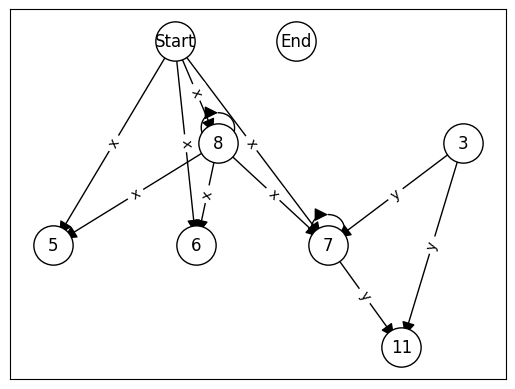

In [62]:
create_ddg(cfg).plot()

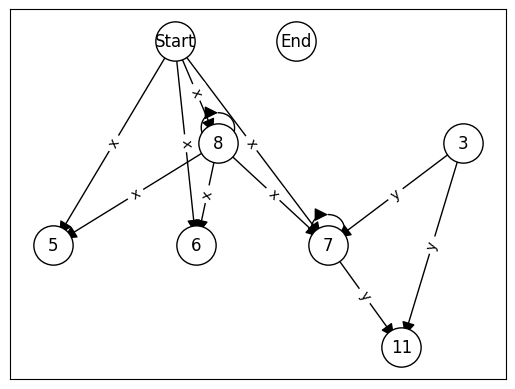

In [63]:
create_ddg(cfg).plot()

## Program Dependence Graph

The program dependence graph represents all dependencies in a program. It essentially is a combination of PDG and DDG.

In [64]:
def create_pdg(cfg):
    # Create unconnected graph
    pdg = nx.DiGraph()
    pdg.add_nodes_from(cfg.nodes())

    ddg = create_ddg(cfg)
    cdg = control_dependence_graph(cfg)
    pdg.add_edges_from(cdg.edges())
    pdg.add_edges_from(ddg.edges()) # TODO: Loses edge labels
    
    return ProgramGraph(pdg, cfg.start, cfg.end)

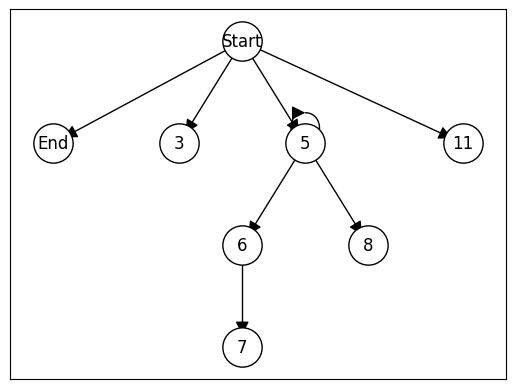

In [65]:
control_dependence_graph(cfg).plot()

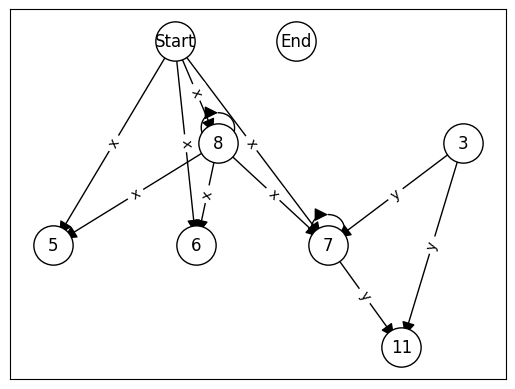

In [66]:
create_ddg(cfg).plot()

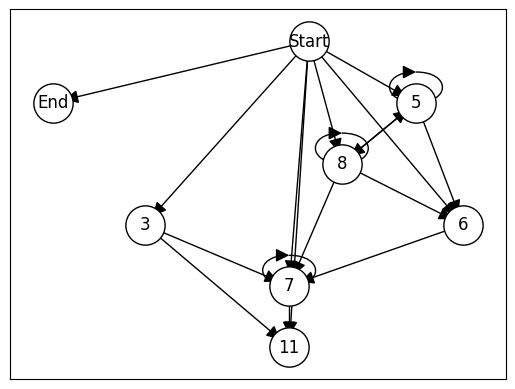

In [67]:
create_pdg(cfg).plot()

## Slicing

Slicing uses the program dependence graph to extract an executable subset of a program that only contains statements relevant for the execution of a target statement, i.e., the slice criterion. We thus need the PDG for our example program to start with, and we need to add a helper function that gives us the transitive predecessors.

In [68]:
class ProgramGraph(ProgramGraph):
    def transitive_predecessors(self, node):
        return nx.nodes(nx.dfs_tree(self.graph.reverse(), node))

A backwards slice gives us information about what set of statements could have affected a statement (or if we want to, even at the level of a specific variable at this statement). A backward slice is simply created by a backwards traversal of the PDG, starting from the slicing criterion.

In [69]:
def backward_slice(code, line):
    tree = parse_method(code)
    cfg = CFGBuilder(tree).create_graph()
    definitions = []
    for node in cfg.nodes():
        definitions.extend(node.definitions())
        
    pdg = create_pdg(cfg)
    target = pdg.node_for_line(line)
    statements = set([str(n) for n in pdg.transitive_predecessors(target)])

    lines = code.split('\n')
    result = lines[1] + "\n"
    for line_no, line in enumerate(lines):
        if str(line_no + 1) in statements:
            result += line + "\n"
            
    return result

In [70]:
code = """
public boolean testMe(int x, int y) {
    if (x <= y) {
        if (x == y) {
            System.out.println("Some output");
        }
        if (x > 0) {
            if (y == 17) {
               return true;
            }
        }
    }
    return false;
}
"""

In [71]:
print(backward_slice(code, 9))

public boolean testMe(int x, int y) {
    if (x <= y) {
        if (x > 0) {
            if (y == 17) {
               return true;



Note that our slice isn't actually compilable, because we did not deal with closing braces. However, in principle we can also get these from the AST.

A forward slice tells us which statements can be affected by a given statement, or variable in that statment. It is determined using a forward traversal of the PDG.

In [72]:
def forward_slice(code, line):
    tree = parse_method(code)
    cfg = CFGBuilder(tree).create_graph()
    definitions = []
    for node in cfg.nodes():
        definitions.extend(node.definitions())
        
    pdg = create_pdg(cfg)
    target = pdg.node_for_line(line) 
    statements = set([str(n) for n in pdg.transitive_successors(target)])

    lines = code.split('\n')
    result = lines[1] + "\n"
    for line_no, line in enumerate(lines):
        if str(line_no + 1) in statements:
            result += line + "\n"
            
    return result

In [73]:
code = """
public boolean testMe(int x, int y) {
    if (x <= y) {
        if (x == y) {
            System.out.println("Some output");
        }
        if (x > 0) {
            if (y == 17) {
               return true;
            }
        }
    }
    return false;
}
"""

In [74]:
print(forward_slice(code, 8))

public boolean testMe(int x, int y) {
            if (y == 17) {
               return true;
    return false;



In [75]:
print(forward_slice(code, 4))

public boolean testMe(int x, int y) {
        if (x == y) {
            System.out.println("Some output");

